In [197]:
%load_ext autoreload
%autoreload 2

from api import PriceAPI

api = PriceAPI(refresh=False)
df, meta = api.load_universe(min_lmt=2000, min_4h_vol=10_000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
meta

,null_ratio,lmt,4h_vol
name,,,
Abyssal bracelet(5),0.357583,10000,1.894828e+04
Adamant arrow,0.022180,11000,2.748526e+05
Adamant arrow(p++),0.237410,11000,3.123426e+04
Adamant arrowtips,0.092801,10000,1.932488e+04
Adamant bolts,0.000382,11000,2.842684e+05
...,...,...,...
Yew shortbow,0.084530,18000,1.763093e+04
Yew shortbow (u),0.344218,10000,3.651259e+04
Young impling jar,0.012154,18000,6.465858e+03


[ 3638.38897023  3602.44059563  3566.67460774 ...,  3737.85563953
  3694.72759899  3646.59166452]
[-283.83198245 -298.1942838  -319.04147251 ...,   20.82716487   65.65044694
  111.39774655]
[ 22176.97058959  22570.31602102  22932.64958493 ...,    934.59511273
    819.9894871     739.41879859]
[ 154061.06200579  151433.02536209  148738.3065432  ..., -192798.24650807
 -199146.45733419 -204668.82974075]
[-1752429.422596   -1761832.44279925 -1771836.6899099  ...,
 -1635938.6220814  -1633257.09949056 -1630869.0112442 ]
[-800171.6063624  -806898.20855733 -813848.30413723 ..., -671958.9100836
 -670797.38750746 -669616.11387707]
[-16425.92815897 -17421.70913549 -18457.33342398 ..., -87407.28874218
 -87964.51601426 -88520.52168609]
[-458715.01488183 -460853.97479635 -463269.03394071 ..., -468465.39326985
 -467231.70591425 -465778.47651407]
[-118472.33913106 -113540.22160866 -109340.67138117 ...,   63301.12453375
   63029.29032176   62905.41629726]
[-30190845.45705735 -30263608.05788594 -3033651

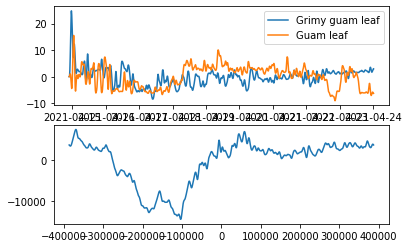

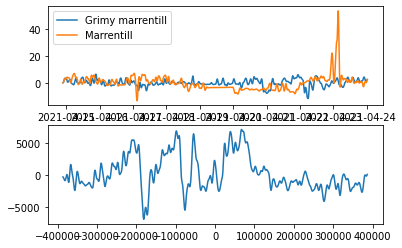

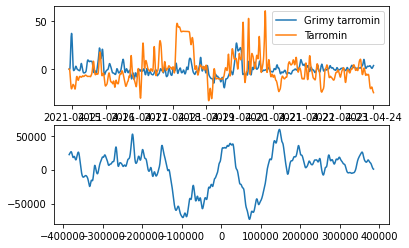

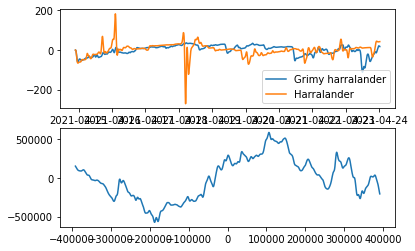

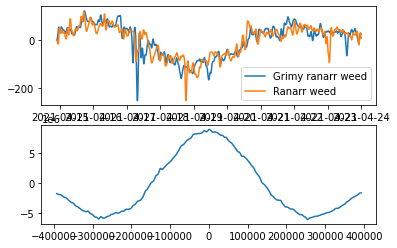

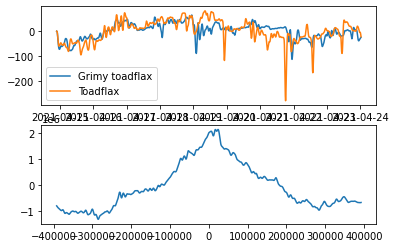

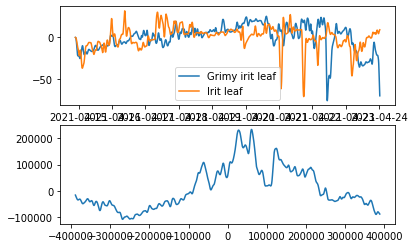

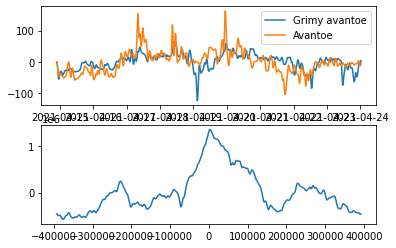

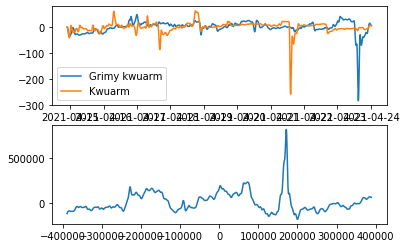

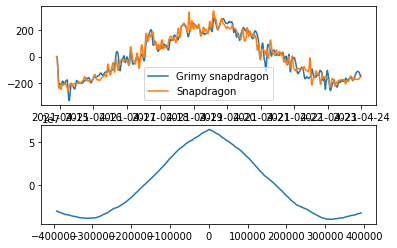

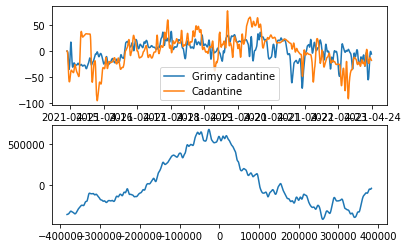

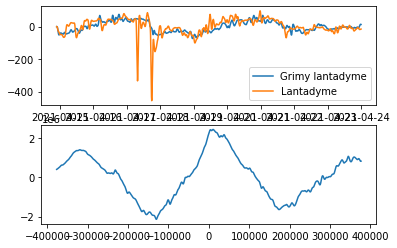

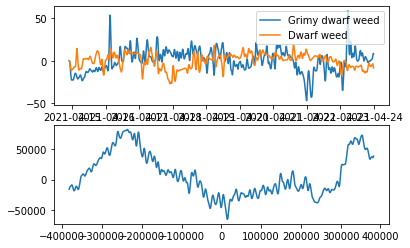

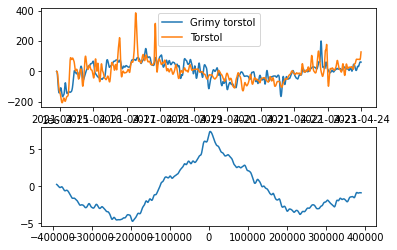

In [134]:
from recipe import HERBS, Recipe
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as sg
import numpy as np
from obspy.signal.detrend import polynomial as detrend_poly
from obspy.signal.filter import lowpass

GRIMY = [f'Grimy {herb.lower()}' for herb in HERBS]

sos = sg.butter(4, 1 / 3600, 'hp', fs=12 / 3600, output='sos')

for herb, grimy in zip(HERBS, GRIMY):

    fig, (axh, axl) = plt.subplots(2)

    hl = df.loc[herb, 'low']
    gl = df.loc[grimy, 'low']
    ix = hl.index.intersection(gl.index)

    hl = hl.reindex(ix).values
    gl = gl.reindex(ix).values

    detrend_poly(hl, order=1)
    detrend_poly(gl, order=1)

    gl = lowpass(gl, .5 / 3600, 12 / 3600)
    hl = lowpass(hl, .5 / 3600, 12 / 3600)

    axh.plot(ix, gl, label=grimy)
    axh.plot(ix, hl, label=herb)


    rate = 12 / 3600
    n = len(ix)

    delay = np.linspace(-0.5 * n / rate, 0.5 * n / rate, n)
    corr = sg.correlate(gl, hl, mode='same')

    axl.plot(delay, corr)
    axh.legend()
    print(corr)




plt.show()

In [135]:
meta

,null_ratio,lmt,4h_vol
name,,,
Abyssal bracelet(5),0.357583,10000,1.894828e+04
Achey tree logs,0.546554,13000,2.237021e+03
Adamant arrow,0.022180,11000,2.748526e+05
Adamant arrow(p),0.572414,11000,1.854124e+03
Adamant arrow(p+),0.686275,11000,1.019294e+03
...,...,...,...
Zenyte amulet (u),0.571429,10000,2.057143e+01
Zenyte shard,0.050739,11000,9.729480e+01
Zogre bones,0.119048,3000,4.508052e+02


In [136]:
%autoreload 2
from recipe import Recipe
SIMPLE_POT_RECIPES = [
    Recipe(
        ingredients={'Ranarr weed': 1, 'Snape grass': 1},
        products={'Prayer potion(3)': 1}
    ),
    Recipe(
        ingredients={'Super energy(4)': 1, 'Amylase crystal': 4},
        products={'Stamina potion(4)': 1}
    ),
    Recipe(
        ingredients={'Raw shark': 1},
        products={'Shark': 1}
    ),
    Recipe(
        ingredients={'Green dragonhide': 1},
        products={'Green dragon leather': 1}
    ),
    Recipe(
        ingredients={'Raw tuna': 1},
        products={'Tuna': 1}
    ),
]

def recipe_lag_plot(api: PriceAPI, recipe: Recipe):
    ing_lows = []
    prod_lows = []

    ix = None
    for set, out in zip(
        [recipe.ingredients, recipe.products],
        [ing_lows, prod_lows]
    ):
        for item, qty in set.items():

            low = df.loc[item, "low"].rolling(24).median().dropna()

            if ix is None:
                ix = low.index
            else:
                ix = ix.intersection(low.index)

            out.append(low)

    ing_total = sum([it.reindex(ix) for it in ing_lows])
    prod_total = sum([it.reindex(ix) for it in prod_lows])

    fig, (axh, axl, axf) = plt.subplots(3)

    axh.set_title(recipe.name)
    axh.legend()

    axh.plot(ix, ing_total, label='ing')
    axh.plot(ix, prod_total, label='prod')

    print(ing_total, prod_total)

    mean = ing_total.mean()

    ing_dt = detrend_poly(ing_total, 3)
    prod_dt = detrend_poly(prod_total, 3)


    rate = 12 * 24
    n = len(ix)
    delay = np.linspace(-0.5 * n / rate, 0.5 * n / rate, n)

    axl.plot(delay, sg.correlate(ing_dt, prod_dt, mode='same'))
    axl.plot(delay, sg.correlate(ing_dt, ing_dt, mode='same'))

    fs, density = sg.periodogram(ing_dt / mean, rate)
    axf.plot(fs, density)
    axf.set_xlim(0, 6)

    plt.show()


# for recipe in SIMPLE_POT_RECIPES:
#     recipe_lag_plot(api, recipe)

In [137]:
print(meta)


                     null_ratio    lmt        4h_vol
name                                                
Abyssal bracelet(5)    0.357583  10000  1.894828e+04
Achey tree logs        0.546554  13000  2.237021e+03
Adamant arrow          0.022180  11000  2.748526e+05
Adamant arrow(p)       0.572414  11000  1.854124e+03
Adamant arrow(p+)      0.686275  11000  1.019294e+03
...                         ...    ...           ...
Zenyte amulet (u)      0.571429  10000  2.057143e+01
Zenyte shard           0.050739  11000  9.729480e+01
Zogre bones            0.119048   3000  4.508052e+02
Zul-andra teleport     0.011868  10000  6.056031e+03
Zulrah's scales        0.000381  30000  3.949956e+06

[1553 rows x 3 columns]


[('Dragon bones', 0.80079223333653127),
 ('Green dragonhide', 0.73658229705529599),
 ('Grimy torstol', 0.7309811760485706),
 ('Soul rune', 0.72443950430708426),
 ('Raw manta ray', 0.72375529272390371),
 ('White berries', 0.68426275044191065),
 ('Astral rune', 0.68035680296448831),
 ('Ruby dragon bolts', 0.67200448697347825),
 ('Mahogany plank', 0.65019706399626698),
 ('Adamant dart', 0.64708711290956822)]


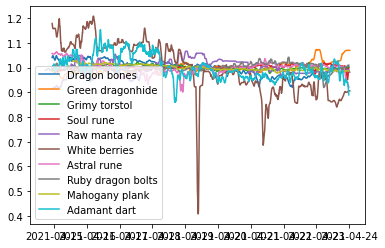

In [202]:
rate = 12 * 24
by_power = {}
for name, item in df.groupby(level=0):

    if len(item) < 100:
        continue

    low = item['low'].rolling(24).median().dropna().values
    detrend_poly(low, 3)

    fs, density = sg.periodogram(low, rate, nfft = 2 * 12 * 24)

    daily_harmonic_ix = [2, 4, 6 ,8, 10]
    daily_power = sum(density[daily_harmonic_ix])
    power_ratio = daily_power / sum(density[1:])
    by_power[name] = power_ratio


from pprint import pprint
by_power = sorted(by_power.items(), key=lambda x: -x[1])
pprint(by_power[:10])

for name, power in by_power[:10]:
    plt.plot(df.loc[name, 'low'].rolling(12).mean() / df.loc[name, 'low'].mean(), label=name)

plt.legend()
plt.show()